In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os


from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization

In [2]:
train_dataset = 'dataset/training/' 
test_dataset = 'dataset/testing/'

We now need to preprocess images within each folder and label them according to their classification.

In [3]:
def preprocess_image(img_path):
    # read in the image
    img = cv2.imread(img_path)

    # convert image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # normalize the image array
    img = img / 255

    # resize the image for uniformity
    img = cv2.resize(img, (256, 256))

    return img

In [53]:
encode = {'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}
decode = {0: 'no_tumor', 1: 'meningioma_tumor', 2: 'glioma_tumor', 3: 'pituitary_tumor'}

def load_data(dataset_path):
    x_data = [] # images
    y_data = [] # labels

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        # check if the path is a directory and skip if not
        if not os.path.isdir(folder_path):
            continue  
        
        for file in os.listdir(folder_path):
            # find path of the image
            file_path = os.path.join(folder_path, file)

            # preprocess the image
            img = preprocess_image(file_path)

            # append the new image to the x array
            x_data.append(img)

            # append the label to the y array
            y_data.append(encode[folder])
    
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    
    return x_data, y_data


In [5]:
x_train, y_train = load_data(train_dataset)
x_test, y_test = load_data(test_dataset)

Let us take a look at some images within our dataset.

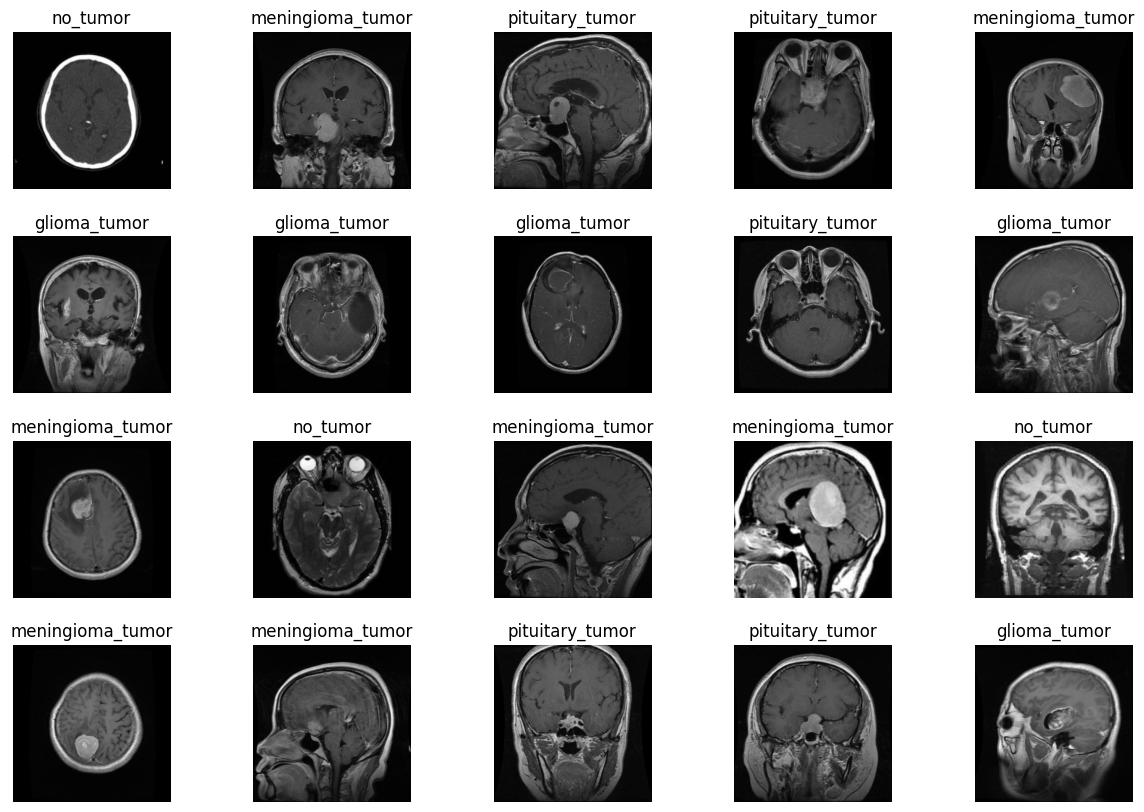

In [60]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.ravel()
for i in range(0, 20):
    index = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[index], cmap='gray')
    axes[i].set_title(decode[y_train[index]])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.3)
plt.show()

Now with our data we can create our model.

In [6]:
num_classes = len(np.unique(y_train))

def build_model(num_classes=4, input_shape=(256, 256, 1)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=7, activation='relu', padding="SAME",input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding="SAME"),
        tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding="SAME"),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding="SAME"),
        tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding="SAME"),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [7]:
def train_model(model, x_train, y_train, x_test, y_test, batch_size=0, epochs=10):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
    return history

In [8]:
model = build_model()
history = train_model(model, x_train, y_train, x_test, y_test, epochs=1)

90/90 [==============================] - 562s 6s/step - loss: 1.3152 - accuracy: 0.3662 - val_loss: 1.5718 - val_accuracy: 0.2310


With this working model, we can evaluate the model and make our observations via the following metrics.

In [34]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.title('Neural Network Accuracy')
    plt.show()

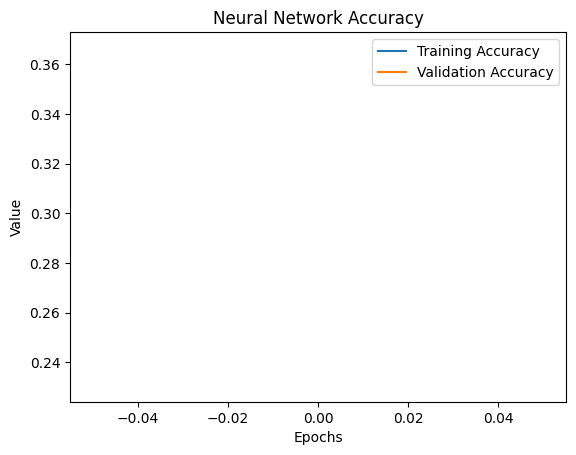

In [35]:
plot_accuracy(history)

In [36]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title('Neural Network Loss')
    plt.show()

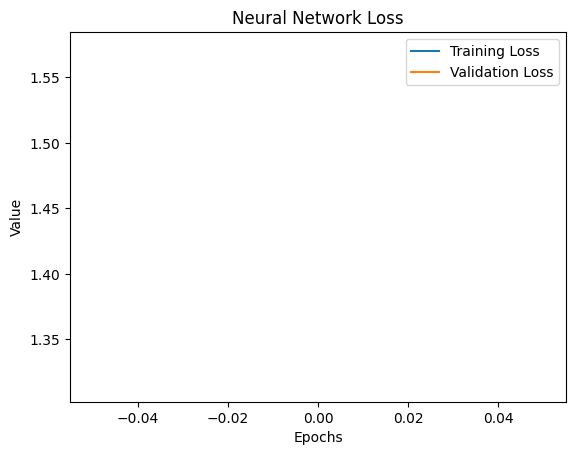

In [37]:
plot_loss(history)

In [25]:
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label.keys())
    display.plot()

13/13 [==============================] - 21s 2s/step


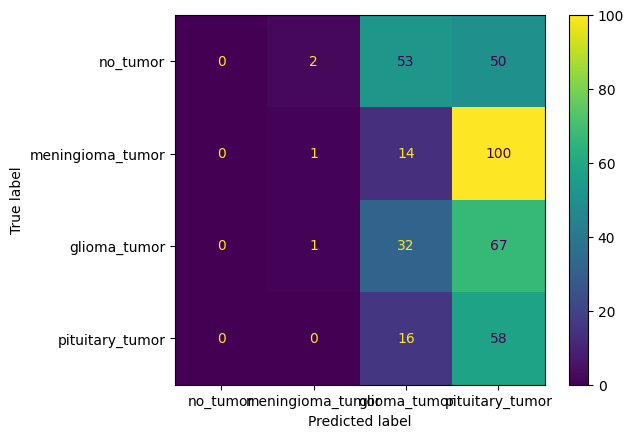

In [26]:
plot_confusion_matrix(model, x_test, y_test)

Finally, we can use our model to make predictions on images outside of our dataset through the following.

In [51]:
# make a prediction function
def predict_image(model, img):
    img = preprocess_image(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    prediction = np.argmax(prediction)
    return decode[prediction]

In [54]:
predict_image(model, 'dataset/glioma.jpg')

1/1 [==============================] - 0s 68ms/step


'glioma_tumor'